# Benchmarks analysis

This notebook aims to assess our model's performances on two synthetic benchkmarks of abnormalities:
- deletion benchmark: simple surfaces of various sizes have been randomly deleted
- asymmetry benchmark: equivalent crop but on left hemisphere and then flipped

In [1]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from preprocess import InpaintDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.svm import LinearSVC

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [50]:
#model_dir = '/volatile/lg261972/inpainting/gridsearch_all/n_100_kl_2_lr_0.0001_bs_8/checkpoint.pt'
model_dir = '/neurospin/dico/lguillon/inpainting/exp_comp/ss_properties/500_2/checkpoint.pt'
model = VAE((1, 80, 80, 96), 100, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

## Loading of HCP test data

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = '/neurospin/dico/data/deep_folding/current/datasets/' \
                        'hcp/crops/1mm/SC/no_mask/'

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

filenames = np.load(os.path.join(data_dir, 'Rskeletons', 'sub_id.npy'))
distmaps = np.load(os.path.join(data_dir, 'Rskel_distmaps', "skel_distmap_1mm.npy"),
                   mmap_mode='r')

skeletons = np.load(os.path.join(data_dir, "Rskeletons",
                                "skeletons_1mm.npy"),
                   mmap_mode='r')

foldlabels = np.load(os.path.join(data_dir, 'Rfoldlabels', "foldlabels_1mm.npy"),
                   mmap_mode='r')
    
print(distmaps.shape, filenames.shape)

# Selection of test set only
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, np.array(test_list['subjects']), sorter=sorter)]
filenames = filenames[filenames_idx]
distmaps = distmaps[filenames_idx]
skeletons = skeletons[filenames_idx]
foldlabels = foldlabels[filenames_idx]

print(distmaps.shape)

(1114, 78, 63, 88, 1) (1114,)
(200, 78, 63, 88, 1)


In [5]:
subset = InpaintDataset(foldlabels=foldlabels,
                        skeletons=skeletons,
                        distmaps=distmaps,
                        filenames=filenames,
                        data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

inpaint


In [6]:
dico_set_loaders_hcp = {'hcp': testloader}

root_dir = '/neurospin/dico/lguillon/inpainting/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_hcp = tester_hcp.test()
encoded_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
recon_hcp = {loader_name:[int(results_hcp[loader_name][k][2].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
input_hcp = {loader_name:[results_hcp[loader_name][k][3].cpu().detach().numpy() for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['latent'] = encoded_hcp['hcp'] 
df_encoded_hcp['loss'] = losses_hcp['hcp'] 
df_encoded_hcp['recon'] = recon_hcp['hcp'] 
df_encoded_hcp['input'] = input_hcp['hcp'] 
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))]
df_encoded_hcp['sub'] = list(filenames)

hcp


### Loading of deletion benchmark

In [7]:
data_dir = '/neurospin/dico/lguillon/inpainting/benchmark/deletion/'

In [8]:
distmaps_200 = np.load(os.path.join(data_dir, "200", "del_200_distmap.npy"),
                   mmap_mode='r')
skeletons_200 = np.load(os.path.join(data_dir, "200", "del_200_skel.npy"),
                   mmap_mode='r')
foldlabels_200 = np.load(os.path.join(data_dir, "200", "del_200_label.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", "sub_id_skel.npy"))


subset_200 = InpaintDataset(foldlabels=foldlabels_200,
                        skeletons=skeletons_200,
                        distmaps=distmaps_200,
                        filenames=filenames_200,
                        data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_500 = np.load(os.path.join(data_dir, "500", "del_500_distmap.npy"),
                   mmap_mode='r')
skeletons_500 = np.load(os.path.join(data_dir, "500", "del_500_skel.npy"),
                   mmap_mode='r')
foldlabels_500 = np.load(os.path.join(data_dir, "500", "del_500_label.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", "sub_id_skel.npy"))


subset_500 = InpaintDataset(foldlabels=foldlabels_500,
                        skeletons=skeletons_500,
                        distmaps=distmaps_500,
                        filenames=filenames_500,
                        data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_700 = np.load(os.path.join(data_dir, "700", "del_700_distmap.npy"),
                   mmap_mode='r')
skeletons_700 = np.load(os.path.join(data_dir, "700", "del_700_skel.npy"),
                   mmap_mode='r')
foldlabels_700 = np.load(os.path.join(data_dir, "700", "del_700_label.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", "sub_id_skel.npy"))


subset_700 = InpaintDataset(foldlabels=foldlabels_700,
                        skeletons=skeletons_700,
                        distmaps=distmaps_700,
                        filenames=filenames_700,
                        data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_1000 = np.load(os.path.join(data_dir, "1000", "del_1000_distmap.npy"),
                   mmap_mode='r')
skeletons_1000 = np.load(os.path.join(data_dir, "1000", "del_1000_skel.npy"),
                   mmap_mode='r')
foldlabels_1000 = np.load(os.path.join(data_dir, "1000", "del_1000_label.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", "sub_id_skel.npy"))


subset_1000 = InpaintDataset(foldlabels=foldlabels_1000,
                        skeletons=skeletons_1000,
                        distmaps=distmaps_1000,
                        filenames=filenames_1000,
                        data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

inpaint
inpaint
inpaint
inpaint


In [9]:
dico_set_loaders = {'200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}
#dico_set_loaders = {'500': loader_500}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_deletion = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=75, depth=3)

results_deletion = tester_deletion.test()
encoded_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[int(results_deletion[loader_name][k][0].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[int(results_deletion[loader_name][k][2].cpu().detach().numpy()) for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_deletion = {loader_name:[results_deletion[loader_name][k][3].cpu().detach().numpy() for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

200
500
700
1000


In [10]:
df_encoded_deletion = pd.DataFrame()
df_encoded_deletion['latent'] = encoded_deletion['200'] +encoded_deletion['500']+ encoded_deletion['700'] +encoded_deletion['1000']  
df_encoded_deletion['loss'] = losses_deletion['200'] + losses_deletion['500'] + losses_deletion['700'] + losses_deletion['1000'] 
df_encoded_deletion['recon'] = recon_deletion['200'] + recon_deletion['500'] +recon_deletion['700'] + recon_deletion['1000']  
df_encoded_deletion['input'] = input_deletion['200'] + input_deletion['500'] + input_deletion['700'] + input_deletion['1000']
df_encoded_deletion['sub'] = list(filenames_200) + list(filenames_500) + list(filenames_700) + list(filenames_1000)
df_encoded_deletion['group'] = ['200' for k in range(len(list(filenames_200)))] + ['500' for k in range(len(list(filenames_500)))] + ['700' for k in range(len(list(filenames_700)))] + ['1000' for k in range(len(list(filenames_1000)))]

In [11]:
deletion_200 = pd.DataFrame()
deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_deletion['200']   
deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

In [12]:
deletion_500 = pd.DataFrame()
deletion_500['latent'] = encoded_deletion['500']  
deletion_500['loss'] = losses_deletion['500'] 
deletion_500['recon'] = recon_deletion['500']  
deletion_500['input'] = input_deletion['500']
deletion_500['sub'] = list(filenames_500)

deletion_700 = pd.DataFrame()
deletion_700['latent'] = encoded_deletion['700']  
deletion_700['loss'] = losses_deletion['700'] 
deletion_700['recon'] = recon_deletion['700']  
deletion_700['input'] = input_deletion['700']
deletion_700['sub'] = list(filenames_700)

deletion_1000 = pd.DataFrame()
deletion_1000['latent'] = encoded_deletion['1000']  
deletion_1000['loss'] = losses_deletion['1000'] 
deletion_1000['recon'] = recon_deletion['1000']  
deletion_1000['input'] = input_deletion['1000']
deletion_1000['sub'] = list(filenames_1000)

In [13]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub')
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub')
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [14]:
len(deletion_all)

10

### Benchmark 200

In [15]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 90)
df_encoded_200_X = deletion_200[deletion_200['sub'].isin(list_encoded_200)]

list_ctrl = list(set(list(deletion_200['sub'])) - set(list(df_encoded_200_X['sub'])))
df_encoded_hcp_X_200 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [18]:
# list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
# df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

# list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'].astype(int))))
# df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [19]:
# random_ctrl = random.sample(list(df_encoded_hcp['sub'][:200]), 100)

In [20]:
# random_deletion = list(set(list(deletion_200['sub'].astype(int))) - set(random_ctrl))

In [21]:
# df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(random_deletion)]
# df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [16]:
X_200 = np.array(list(df_encoded_200_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_200['latent']))
X_all = np.array(list(df_encoded_hcp_X_200['latent']) + list(df_encoded_200_X['latent']))

labels_200 = np.array(list(df_encoded_hcp_X_200['Group']) + ['200' for k in range(len(df_encoded_200_X))])

In [17]:
reducer = umap.UMAP()
embedding_200 = reducer.fit_transform(X_all)

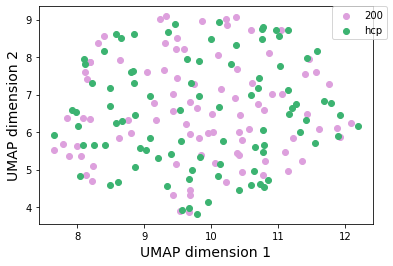

In [18]:
arr = embedding_200
color_dict = {'hcp':'mediumseagreen', '200': 'plum'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_200):
    ix = np.where(labels_200 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

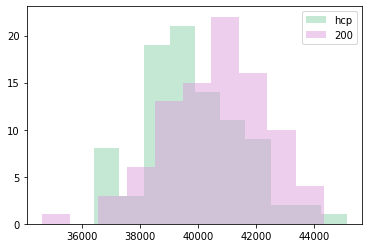

In [19]:
assert(len(df_encoded_hcp_X_200.recon)==90)
assert(len(df_encoded_200_X.recon)==90)
plt.subplot()
plt.hist(df_encoded_hcp_X_200.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_200_X.recon, color='plum', alpha=0.5, label='200')
plt.legend()

In [20]:
F,p = mannwhitneyu(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)

0.0008829563766393917
0.002554851889363438


### Benchmark 500

In [25]:
# df_encoded_500_X = deletion_500

# list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'].astype(int))))
# random_ctrl = random.sample(list_ctrl, 100)
# df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

In [21]:
list_encoded_500 = random.sample(list(deletion_500['sub']), 34)
df_encoded_500_X = deletion_500[deletion_500['sub'].isin(list_encoded_500)]

list_ctrl = list(set(list(deletion_500['sub'])) - set(list(df_encoded_500_X['sub'])))
df_encoded_hcp_X_500 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [22]:
X_500 = np.array(list(df_encoded_500_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_500['latent']))
X_all = np.array(list(df_encoded_hcp_X_500['latent']) + list(df_encoded_500_X['latent']))

labels_500 = np.array(list(df_encoded_hcp_X_500['Group']) + ['500' for k in range(len(df_encoded_500_X))])
reducer = umap.UMAP()
embedding_500 = reducer.fit_transform(X_all)

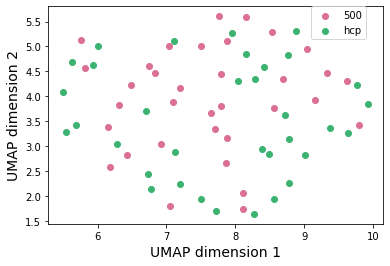

In [23]:
arr = embedding_500
color_dict = {'hcp':'mediumseagreen', '500': 'palevioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_500):
    ix = np.where(labels_500 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(0.95,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

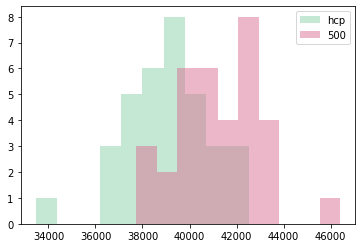

In [24]:
assert(len(df_encoded_hcp_X_500.recon)==34)
assert(len(df_encoded_500_X.recon)==34)
plt.subplot()
plt.hist(df_encoded_hcp_X_500.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_500_X.recon, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [25]:
F,p = mannwhitneyu(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)

1.0687839571661643e-05
7.290598883990942e-05


### Benchmark 700

In [28]:
# list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
# df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

# list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'].astype(int))))
# df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [26]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 54)
df_encoded_700_X = deletion_700[deletion_700['sub'].isin(list_encoded_700)]

list_ctrl = list(set(list(deletion_700['sub'])) - set(list(df_encoded_700_X['sub'])))
df_encoded_hcp_X_700 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [27]:
X_700 = np.array(list(df_encoded_700_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_700['latent']))
X_all = np.array(list(df_encoded_hcp_X_700['latent']) + list(df_encoded_700_X['latent']))

#X_embedded_700 = TSNE(n_components=2).fit_transform(X_all)
labels_700 = np.array(list(df_encoded_hcp_X_700['Group']) + ['700' for k in range(len(df_encoded_700_X))])
reducer = umap.UMAP()
embedding_700 = reducer.fit_transform(X_all)

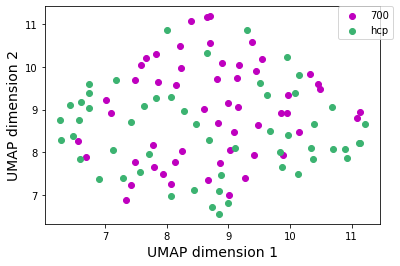

In [28]:
arr = embedding_700
color_dict = {'hcp':'mediumseagreen', '700': 'm'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_700):
    ix = np.where(labels_700 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

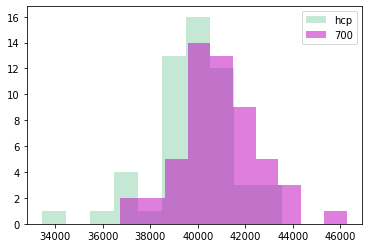

In [29]:
assert(len(df_encoded_hcp_X_700.recon)==54)
assert(len(df_encoded_700_X.recon)==54)
plt.subplot()
plt.hist(df_encoded_hcp_X_700.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_700_X.recon, color='m', alpha=0.5, label='700')
plt.legend()

In [30]:
F,p = mannwhitneyu(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)

0.0013702560286361963
0.013451203177272606


### Benchmark 1000

In [31]:
# list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
# df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(int).isin(list_encoded_1000)]

# list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'].astype(int))))
# df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [31]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 75)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].isin(list_encoded_1000)]

list_ctrl = list(set(list(deletion_1000['sub'])) - set(list(df_encoded_1000_X['sub'])))
df_encoded_hcp_X_1000 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [32]:
X_1000 = np.array(list(df_encoded_1000_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X_1000['latent']))
X_all = np.array(list(df_encoded_hcp_X_1000['latent']) + list(df_encoded_1000_X['latent']))

#X_embedded_1000 = TSNE(n_components=2, perplexity=15).fit_transform(X_all)
labels_1000 = np.array(list(df_encoded_hcp_X_1000['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])
reducer = umap.UMAP()
embedding_1000 = reducer.fit_transform(X_all)

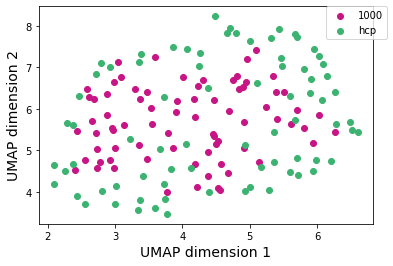

In [33]:
arr = embedding_1000
color_dict = {'hcp':'mediumseagreen', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_1000):
    ix = np.where(labels_1000 == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

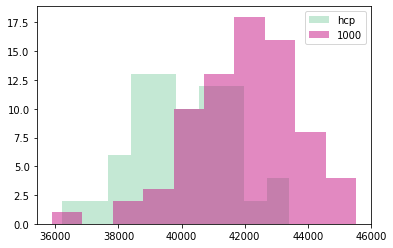

In [34]:
assert(len(df_encoded_hcp_X_1000.recon)==76)
assert(len(df_encoded_1000_X.recon)==75)
plt.subplot()
plt.hist(df_encoded_hcp_X_1000.recon, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_1000_X.recon, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [35]:
F,p = mannwhitneyu(df_encoded_hcp_X_700.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_700.loss, df_encoded_1000_X.loss)
print(p)

3.8968283628177944e-10
1.843697248726375e-08


### ALL

In [36]:
X = np.array(list(df_encoded_hcp['latent']) +
             list(deletion_200['latent']) +
             list(deletion_500['latent']) +
             list(deletion_700['latent']) +
             list(deletion_1000['latent']))
labels = np.array(list(df_encoded_hcp['Group']) + 
                  ['200' for k in range(len(deletion_200))] +
                  ['500' for k in range(len(deletion_500))] +
                  ['700' for k in range(len(deletion_700))] +
                  ['1000' for k in range(len(deletion_1000))])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X)

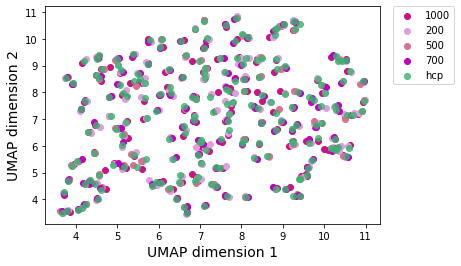

In [37]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', '200': 'plum', '500': 'palevioletred', '700': 'm', '1000': 'mediumvioletred'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, c = color_dict[g], label = g_lab, alpha=0.8)
    else:
        ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

## Trajectories

In [38]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [39]:
list_encoded_all = list(deletion_all['sub'])
df_encoded_all_X = deletion_all

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_all_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [40]:
X_del_all = np.array(list(df_encoded_all_X['latent_200']) + list(df_encoded_all_X['latent_500']) + list(df_encoded_all_X['latent_700']) + list(df_encoded_all_X['latent_1000']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_all_X['latent_200']) + list(df_encoded_all_X['latent_500']) + list(df_encoded_all_X['latent_700']) + list(df_encoded_all_X['latent_1000']))

labels_all =np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(10)] + ['500' for k in range(10)] + ['700' for k in range(10)] + ['1000' for k in range(10)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

In [47]:
X_all = np.array(list(df_encoded_hcp_X['latent']) + [df_encoded_all_X[k][0] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][1] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][2] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][3] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][4] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][5] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][6] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][7] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][8] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] +
                                                    [df_encoded_all_X[k][9] for k in ['latent_200', 'latent_500', 'latent_700', 'latent_1000']] )

labels_all = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(10)] + ['500' for k in range(10)] + ['700' for k in range(10)] + ['1000' for k in range(10)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)
#embedding_all = reducer.fit_transform(np.array(list(df_encoded_hcp_X['latent'])))

In [42]:
embedding_del = reducer.transform(X_del_all)

In [44]:
labels_all.shape

(240,)

In [46]:
embedding_all.shape

(200, 2)

['1000' '200' '500' '700' 'hcp']
[230 231 232 233 234 235 236 237 238 239]
[200 201 202 203 204 205 206 207 208 209]
[210 211 212 213 214 215 216 217 218 219]
[220 221 222 223 224 225 226 227 228 229]


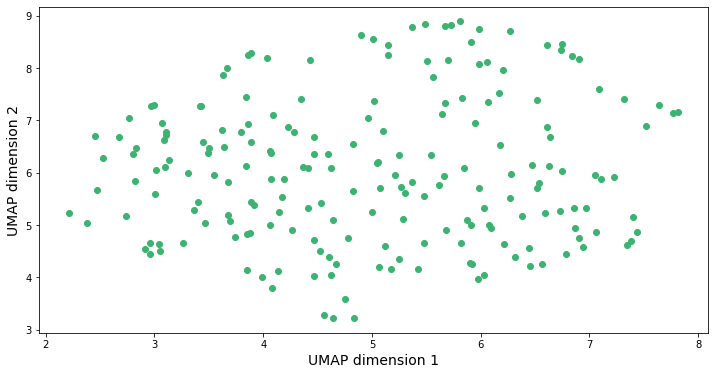

In [48]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,6))
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
    else:
        for i in ix:
            print(i)
            if 190 in i:
                print(g)
                ax.scatter(x, y, c=color_dict['sub1'], label = g_lab, marker=marker_dict[g])
            elif 191 in i:
                ax.scatter(x, y, c=color_dict['sub2'], label = g_lab, marker=marker_dict[g])
            elif 192 in i:
                ax.scatter(x, y, c=color_dict['sub3'], label = g_lab, marker=marker_dict[g])
            elif 193 in i:
                ax.scatter(x, y, c=color_dict['sub4'], label = g_lab, marker=marker_dict[g])
    
#plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

['1000' '200' '500' '700' 'hcp']


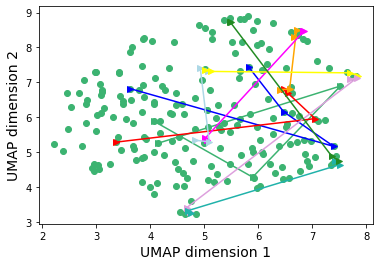

In [49]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure()
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([embedding_all[k:k+4][i][0] for i in range(4)], 
            [embedding_all[k:k+4][i][1] for i in range(4)], '->',c=list(color_dict.values())[idx])

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

['1000' '200' '500' '700' 'hcp']


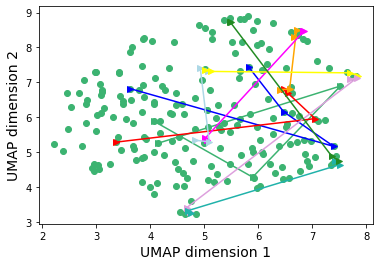

In [50]:
arr = np.array(list(embedding_all) + list(embedding_del))
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure()
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(190, 227, 4)):
    ax.plot([arr[k:k+4][i][0] for i in range(4)], 
            [arr[k:k+4][i][1] for i in range(4)], '->',c=list(color_dict.values())[idx])

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Trajectory 200-1000

In [52]:
df_200_1000 = pd.merge(deletion_200, deletion_1000, how='inner', on='sub', suffixes=('_200', '_1000'))

list_encoded_all = list(df_200_1000['sub'])[:200]
df_200_1000_X = df_200_1000

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_200_1000_X['sub'][:20].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_all = np.array(list(df_encoded_hcp_X['latent']) + [df_200_1000[k][0] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][1] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][2] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][3] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][4] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][5] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][6] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][7] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][8] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][9] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][10] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][11] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][12] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][13] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][14] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][15] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][16] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][17] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][18] for k in ['latent_200', 'latent_1000']] +
                                                    [df_200_1000[k][19] for k in ['latent_200', 'latent_1000']] )

labels_all = np.array(list(df_encoded_hcp_X['Group']) + ['200' for k in range(20)] + ['1000' for k in range(20)])
reducer = umap.UMAP()
embedding_all = reducer.fit_transform(X_all)

In [53]:
len(list(df_encoded_hcp_X['Group']))

200

In [54]:
embedding_all.shape

(240, 2)

['1000' '200' 'hcp']


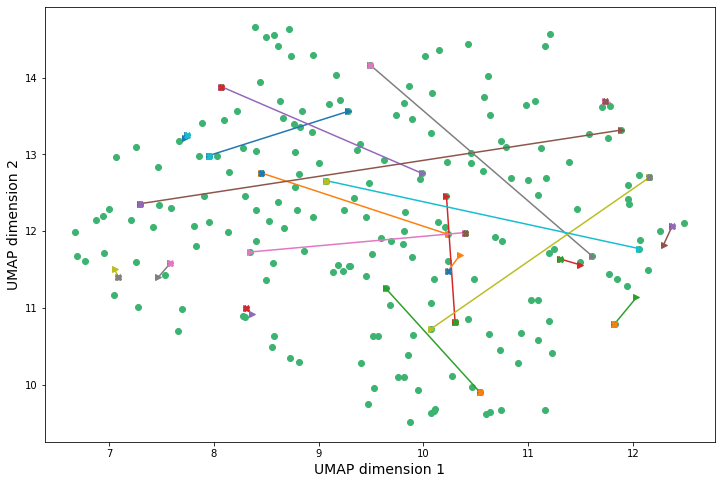

In [55]:
arr = embedding_all
color_dict = {'hcp':'mediumseagreen', 'sub1': 'blue', 'sub2': 'red', 'sub3':'orange', 'sub4': 'magenta',
             'sub5': 'lightblue', 'sub6': 'yellow', 'sub7':'plum', 'sub8': 'lightseagreen','sub9':'forestgreen'}
marker_dict = {'hcp': 'o', '200': 'x', '500': 'v', '700': '^', '1000': 'D'}

fig = plt.figure(figsize=(12,8))
ax = fig.subplots()

print( np.unique(labels_all))
for g in np.unique(labels_all):
    ix = np.where(labels_all == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    if g=='hcp':
        ax.scatter(x, y, color='mediumseagreen', label = g_lab, marker=marker_dict[g])
for idx, k in enumerate(range(180, 217, 2)):
    ax.plot([embedding_all[k:k+2][i][0] for i in range(2)], 
            [embedding_all[k:k+2][i][1] for i in range(2)], '->')
for idx, k in enumerate(range(180, 217, 2)):
    ax.plot([embedding_all[k:k+2][0][0]], 
            [embedding_all[k:k+2][0][1]], 'X')

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

### Quantification

#### SS_size = 200

In [38]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 90)
df_encoded_200_X = deletion_200[deletion_200['sub'].isin(list_encoded_200)]

list_ctrl = list(set(list(deletion_200['sub'])) - set(list(df_encoded_200_X['sub'])))
df_encoded_hcp_X_200 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X = np.array(list(df_encoded_hcp_X_200['latent']) + list(df_encoded_200_X['latent']))
label = np.array(['hcp' for k in range(len(df_encoded_hcp_X_200))] + ['200' for k in range(len(df_encoded_200_X))])

>acc=0.528, est=0.556, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.417, est=0.520, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.444, est=0.458, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.500, est=0.493, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.556, est=0.492, cfg={'C': 1.2, 'penalty': 'l2'}


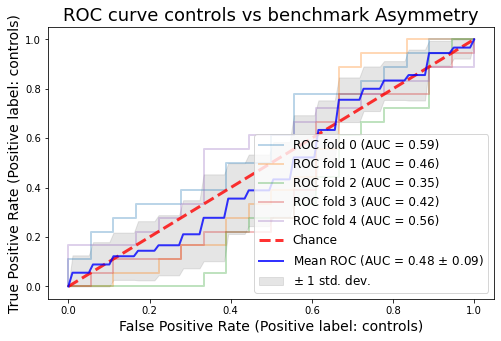

Accuracy: 0.489 (0.052)


In [39]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 500

In [40]:
list_encoded_500 = random.sample(list(deletion_500['sub']), 34)
df_encoded_500_X = deletion_500[deletion_500['sub'].isin(list_encoded_500)]

list_ctrl = list(set(list(deletion_500['sub'])) - set(list(df_encoded_500_X['sub'])))
df_encoded_hcp_X_500 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X = np.array(list(df_encoded_hcp_X_500['latent']) + list(df_encoded_500_X['latent']))
label = np.array(['hcp' for k in range(len(df_encoded_hcp_X_500))] + ['200' for k in range(len(df_encoded_500_X))])

>acc=0.786, est=0.707, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.786, est=0.740, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.714, est=0.702, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.692, est=0.545, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.538, est=0.764, cfg={'C': 0.7, 'penalty': 'l2'}


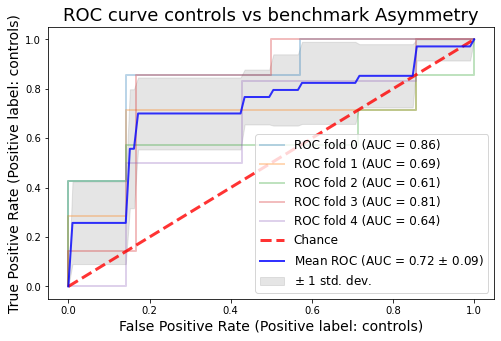

Accuracy: 0.703 (0.091)


In [41]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 700

In [42]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 54)
df_encoded_700_X = deletion_700[deletion_700['sub'].isin(list_encoded_700)]

list_ctrl = list(set(list(deletion_700['sub'])) - set(list(df_encoded_700_X['sub'])))
df_encoded_hcp_X_700 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X = np.array(list(df_encoded_hcp_X_700['latent']) + list(df_encoded_700_X['latent']))
label = np.array(['hcp' for k in range(len(df_encoded_hcp_X_700))] + ['200' for k in range(len(df_encoded_700_X))])

>acc=0.591, est=0.501, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.636, est=0.500, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.545, est=0.535, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.667, est=0.586, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.571, est=0.656, cfg={'C': 0.7, 'penalty': 'l2'}


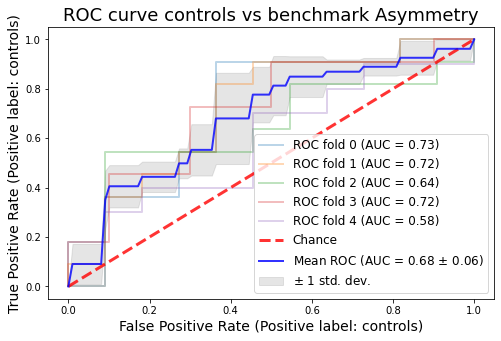

Accuracy: 0.602 (0.044)


In [43]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

#### SS_size = 1000

In [44]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 75)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].isin(list_encoded_1000)]

list_ctrl = list(set(list(deletion_1000['sub'])) - set(list(df_encoded_1000_X['sub'])))
df_encoded_hcp_X_1000 = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X = np.array(list(df_encoded_hcp_X_1000['latent']) + list(df_encoded_1000_X['latent']))
label = np.array(list(df_encoded_hcp_X_1000['Group']) + ['1000' for k in range(len(df_encoded_1000_X))])

>acc=0.839, est=0.792, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.767, est=0.760, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.733, est=0.768, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.833, est=0.735, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.900, est=0.801, cfg={'C': 1, 'penalty': 'l2'}


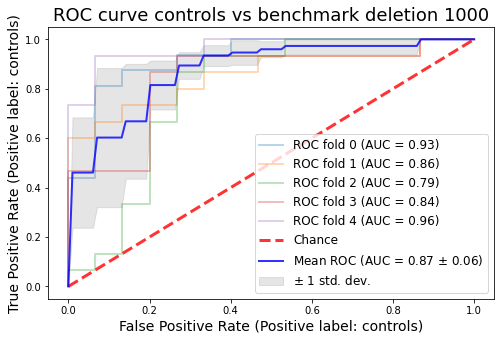

Accuracy: 0.814 (0.059)


In [45]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X, label):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = label[train_ix], label[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark deletion 1000', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [46]:
logreg = LogisticRegression(random_state=0, max_iter=500)
logreg.fit(X_train, y_train)
print(logreg.score(X_test, y_test))
imp = logreg.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

0.9
(0.742072440303434, 0.7710688199743915, 0.7737036845424734, 0.8535292415264041, 0.9065568017877683) (91, 65, 37, 47, 61)


In [59]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
print(gb.score(X_test, y_test))
imp = gb.feature_importances_
imp, names = zip(*sorted(list(zip(imp, [k for k in range(len(imp))]))))
print(imp[-5:], names[-5:])

0.5333333333333333
(0.03731115846928029, 0.04909254549527266, 0.10333220798670313, 0.1189992357531542, 0.18235174806764193) (92, 67, 7, 12, 72)


## Benchmark Asymmetry

In [47]:
data_dir = '/neurospin/dico/lguillon/inpainting/benchmark/asymmetry/flip/'

In [48]:
distmaps_asym = np.load(os.path.join(data_dir, "asym_distmaps.npy"),
                   mmap_mode='r')
skeletons_asym = np.load(os.path.join(data_dir, "asym_skel.npy"),
                   mmap_mode='r')
foldlabels_asym = np.load(os.path.join(data_dir, "asym_labels.npy"),
                   mmap_mode='r')
filenames_asym = np.load(os.path.join(data_dir, "sub_id_skel.npy"))


subset_asym = InpaintDataset(foldlabels=foldlabels_asym,
                        skeletons=skeletons_asym,
                        distmaps=distmaps_asym,
                        filenames=filenames_asym,
                        data_transforms=False)
loader_asym = torch.utils.data.DataLoader(
               subset_asym,
               batch_size=1,
               num_workers=1,
               shuffle=False)

inpaint


In [51]:
dico_set_loaders = {'asymmetry': loader_asym}

root_dir = '/neurospin/dico/lguillon/distmap/benchmark/results/'

criterion = nn.MSELoss(reduction='sum')
tester_asym = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_asym = tester_asym.test()
encoded_asym = {loader_name:[results_asym[loader_name][k][1] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_asym = {loader_name:[int(results_asym[loader_name][k][0].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_asym = {loader_name:[int(results_asym[loader_name][k][2].cpu().detach().numpy()) for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
input_asym = {loader_name:[results_asym[loader_name][k][3].cpu().detach().numpy() for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

asymmetry


In [52]:
df_encoded_asym = pd.DataFrame()
df_encoded_asym['latent'] = encoded_asym['asymmetry']
df_encoded_asym['loss'] = losses_asym['asymmetry']  
df_encoded_asym['recon'] = recon_asym['asymmetry']   
df_encoded_asym['input'] = input_asym['asymmetry'] 
df_encoded_asym['sub'] = list(filenames_asym) 

In [66]:
# X_asym = np.array(list(df_encoded_asym['latent']))
# X_hcp = np.array(list(df_encoded_hcp['latent']))
# X_all = np.array(list(df_encoded_hcp['latent']) + list(df_encoded_asym['latent']))

# labels_asym = np.array(list(df_encoded_hcp['Group']) + ['asymmetry' for k in range(len(df_encoded_asym))])
# reducer = umap.UMAP(random_state=14)
# embedding_asym = reducer.fit_transform(X_all)

In [53]:
random.seed(a=12)
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

X_asym = np.array(list(df_encoded_asym_X['latent']))
X_hcp = np.array(list(df_encoded_hcp_X['latent']))
X_all = np.array(list(df_encoded_hcp_X['latent']) + list(df_encoded_asym_X['latent']))

labels_asym = np.array(list(df_encoded_hcp_X['Group']) + ['asymmetry' for k in range(len(df_encoded_asym_X))])
reducer = umap.UMAP(random_state=14)
embedding_asym = reducer.fit_transform(X_all)

In [54]:
len(df_encoded_hcp_X)

100

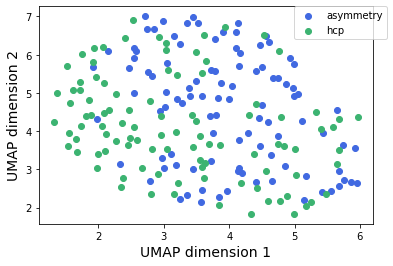

In [55]:
arr = embedding_asym
color_dict = {'hcp':'mediumseagreen', 'asymmetry': 'royalblue'}

fig = plt.figure(figsize=(6,4))
ax = fig.subplots()

for g in np.unique(labels_asym):
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

>acc=0.750, est=0.750, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.725, est=0.775, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.775, est=0.750, cfg={'C': 0.7, 'penalty': 'l2'}
>acc=0.775, est=0.744, cfg={'C': 1, 'penalty': 'l2'}
>acc=0.675, est=0.744, cfg={'C': 0.7, 'penalty': 'l2'}


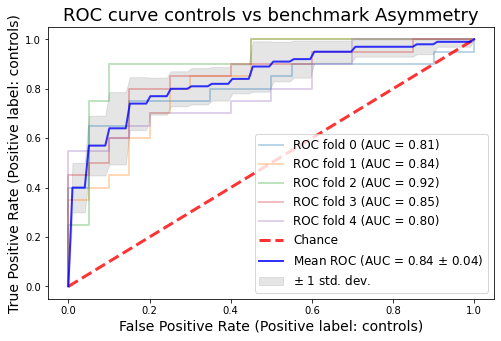

Accuracy: 0.740 (0.037)


In [56]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0
    
for train_ix, test_ix in cv_outer.split(X_all, labels_asym): 
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_asym[train_ix], labels_asym[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = LinearSVC(random_state=1, loss='squared_hinge', max_iter=10000)
    space = dict()
    space['penalty'] = ['l2']
    space['C'] = [0.7, 1, 1.2]
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1  
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

In [57]:
imp = best_model.coef_
imp_abs = list([abs(imp[0][k]) for k in range(len(imp[0]))])
imp_abs, names = zip(*sorted(list(zip(list(imp[0]), [k for k in range(len(imp_abs))]))))
print(imp_abs[-5:], names[-5:])

(0.2862904807453053, 0.3227107520379749, 0.34415033754167185, 0.4965620632010438, 0.5961311852461865) (34, 47, 88, 72, 61)


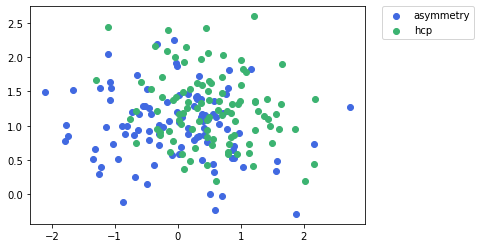

In [58]:
color_dict = {'hcp': 'mediumseagreen', 'asymmetry': 'royalblue'}
most_imp = [72, 61]
arr = np.array([np.array([X_all[i][k] for k in most_imp]) for i in range(len(X_all))])

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(labels_asym):
    #if g == 'HCP' or g == 'leftHanders':
    ix = np.where(labels_asym == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    #ax.scatter(arr[ix][0], arr[ix][1], arr[ix][2], c = color_dict[g], label = g)
    g_lab=g
    ax.scatter(x, y, c = color_dict[g], label = g_lab)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
#ax.legend(fontsize=14)
plt.show()

>acc=0.750, est=0.762, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'exponential', 'n_estimators': 150}
>acc=0.800, est=0.756, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 150}
>acc=0.825, est=0.756, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'n_estimators': 100}
>acc=0.875, est=0.731, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.25, 'loss': 'exponential', 'n_estimators': 75}
>acc=0.725, est=0.750, cfg={'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 150}


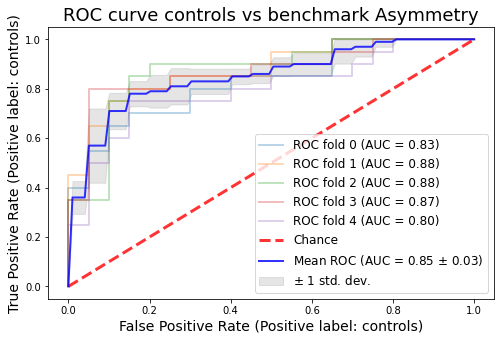

Accuracy: 0.795 (0.053)


In [59]:
fig, ax = plt.subplots(figsize=(8, 5))

cv_outer = StratifiedKFold(n_splits=5)

outer_results = list()
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
i = 0

for train_ix, test_ix in cv_outer.split(X_all, labels_asym):
    X_train, X_test = X_all[train_ix, :], X_all[test_ix, :]
    y_train, y_test = labels_asym[train_ix], labels_asym[test_ix]
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    model = GradientBoostingClassifier(random_state=1)
    space = dict()
    space['loss'] = ['deviance', 'exponential']
    space['learning_rate'] = [0.05, 0.1, 0.2, 0.25]
    space['n_estimators'] = [50, 75, 100, 150]
    space['criterion'] = ['friedman_mse', 'mse']
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = metrics.accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        
    viz = metrics.plot_roc_curve(best_model, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=2, ax=ax)
    i += 1 
    
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve ")
ax.legend(loc="lower right", fontsize='large')
plt.xlabel('False Positive Rate (Positive label: controls)', fontsize=14)
plt.ylabel('True Positive Rate (Positive label: controls)', fontsize=14)
plt.title('ROC curve controls vs benchmark Asymmetry', fontsize=18)
plt.show()
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

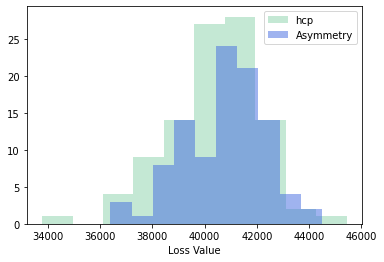

In [60]:
plt.subplot()
#plt.xlim([1100, 4000])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_asym_X.loss, color='royalblue', alpha=0.5, label='Asymmetry') 
plt.xlabel('Loss Value')
plt.legend()

## Folding space - loss distributions

In [69]:
len(df_encoded_deletion)

507

In [70]:
len(df_encoded_200_X)

180

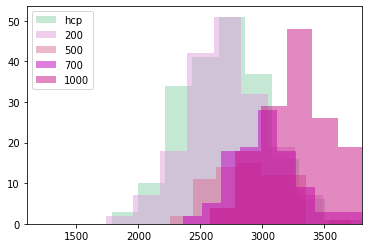

In [71]:
plt.subplot()
plt.xlim([1100, 3800])
plt.hist(df_encoded_hcp.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].loss, color='plum', alpha=0.5, label='200')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].loss, color='palevioletred', alpha=0.5, label='500')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].loss, color='m', alpha=0.5, label='700') 
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].loss, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [72]:
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='200'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='500'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='700'].loss)
print(p)
F,p = mannwhitneyu(df_encoded_hcp.loss, df_encoded_deletion[df_encoded_deletion.group=='1000'].loss)
print(p)

0.2805103679049844
4.187604822313454e-06
7.380906103911546e-17
5.273773743232593e-42


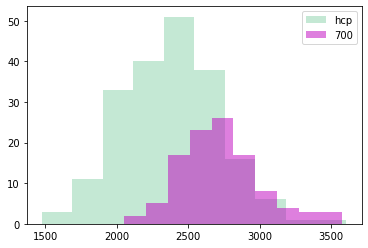

In [76]:
plt.subplot()
plt.hist(df_encoded_hcp.recon, color='mediumseagreen', alpha=0.3, label='hcp')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='200'].recon, color='plum', alpha=0.5, label='200')
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='500'].recon, color='palevioletred', alpha=0.7, label='500')
plt.hist(df_encoded_deletion[df_encoded_deletion.group=='700'].recon, color='m', alpha=0.5, label='700') 
#plt.hist(df_encoded_deletion[df_encoded_deletion.group=='1000'].recon, color='mediumvioletred', alpha=0.7, label='1000')
plt.legend()

In [143]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 100)
df_encoded_200_X = deletion_200[deletion_200['sub'].isin(list_encoded_200)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_200_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

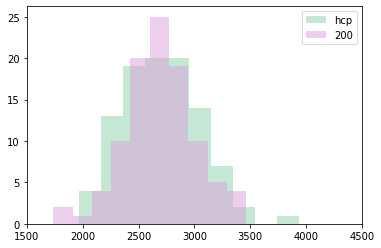

In [144]:
plt.subplot()
plt.xlim([1500, 4500])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_200_X.loss, color='plum', alpha=0.5, label='200')
plt.legend()

In [80]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_200_X.loss)
print(p)

0.3096021074502924
0.5632056973850592


In [138]:
df_encoded_500_X = deletion_500

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_500['sub'])))
random_ctrl = random.sample(list_ctrl, 100)
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(random_ctrl)]

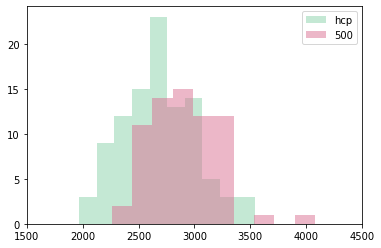

In [139]:
plt.subplot()
plt.xlim([1500, 4500])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_500_X.loss, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [140]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_500_X.loss)
print(p)

1.0265796500613983e-05
0.00020874918560124945


In [134]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 100)
df_encoded_700_X = deletion_700[deletion_700['sub'].isin(list_encoded_700)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_700_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

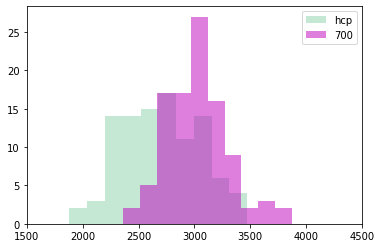

In [135]:
plt.subplot()
plt.xlim([1500, 4500])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_700_X.loss, color='m', alpha=0.5, label='700') 
plt.legend()

In [136]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_700_X.loss)
print(p)

7.263030519368668e-11
2.2056176563845718e-08


In [123]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 100)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].isin(list_encoded_1000)]
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_1000_X['sub'])))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

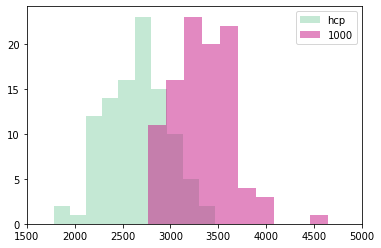

In [133]:
plt.subplot()
plt.xlim([1500, 5000])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_1000_X.loss, color='mediumvioletred', alpha=0.5, label='1000') 
plt.legend()

In [130]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_1000_X.loss)
print(p)

5.459570929393207e-28
3.96731522238869e-25


In [96]:
df_200_500 = pd.merge(deletion_200, deletion_500, how='inner', on='sub', suffixes=('_200', '_500'))
df_700_1000 = pd.merge(deletion_700, deletion_1000, how='inner', on='sub', suffixes=('_700', '_1000'))
deletion_all = pd.merge(df_200_500, df_700_1000, how='inner', on='sub')

In [97]:
list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(deletion_all['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

In [262]:
# plt.subplot()
# plt.xlim([1100, 3800])
# plt.hist(df_encoded_hcp_X[:50].loss, color='mediumseagreen', alpha=0.3, label='hcp')
# # plt.scatter(deletion_all.loss_200[:1], [1], color='plum', alpha=0.8, label='200') 
# # plt.scatter(deletion_all.loss_500[:1], [1], color='palevioletred', alpha=0.8, label='500') 
# # plt.scatter(deletion_all.loss_700[:1], [1], color='m', alpha=0.8, label='700') 
# # plt.scatter(deletion_all.loss_1000[:1], [1], color='mediumvioletred', alpha=0.8, label='1000') 

# plt.scatter(deletion_all.loss_200[1], [2], color='plum', alpha=0.8, label='200', marker='o') 
# plt.scatter(deletion_all.loss_500[1], [2], color='palevioletred', alpha=0.8, label='500', marker='o') 
# plt.scatter(deletion_all.loss_700[1], [2], color='m', alpha=0.8, label='700', marker='o') 
# plt.scatter(deletion_all.loss_1000[1], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='o') 

# plt.plot(deletion_all.loss_200[2], [2], color='plum', alpha=0.8, label='200', marker='->') 
# plt.scatter(deletion_all.loss_500[2], [2], color='palevioletred', alpha=0.8, label='500', marker='->') 
# plt.scatter(deletion_all.loss_700[2], [2], color='m', alpha=0.8, label='700', marker='->') 
# plt.scatter(deletion_all.loss_1000[2], [2], color='mediumvioletred', alpha=0.8, label='1000', marker='->') 

# # plt.scatter(deletion_all.loss_200[3], [3], color='plum', alpha=0.8, label='200', marker='X') 
# # plt.scatter(deletion_all.loss_500[3], [3], color='palevioletred', alpha=0.8, label='500', marker='X') 
# # plt.scatter(deletion_all.loss_700[3], [3], color='m', alpha=0.8, label='700', marker='X') 
# # plt.scatter(deletion_all.loss_1000[3], [3], color='mediumvioletred', alpha=0.8, label='1000', marker='X') 

# # plt.hist(deletion_all.loss_700, color='m', alpha=0.5, label='700') 
# # plt.hist(deletion_all.loss_1000, color='mediumvioletred', alpha=0.5, label='1000') 


# # plt.plot(np.histogram(list(deletion_all.loss_200))[1][:-1],np.histogram(list(deletion_all.loss_200))[0], color='plum', alpha=0.8, label='200') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_500))[1][:-1],np.histogram(list(deletion_all.loss_500))[0], color='palevioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_700))[1][:-1],np.histogram(list(deletion_all.loss_700))[0], color='m', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 
# # plt.plot(np.histogram(list(deletion_all.loss_1000))[1][:-1],np.histogram(list(deletion_all.loss_1000))[0], color='mediumvioletred', alpha=0.8, label='500') # plt.hist(deletion_all.loss_500, color='palevioletred', alpha=0.5, label='500') 

# plt.legend()

In [110]:
delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000 = [], [], [], []
for k in range(len(deletion_all)):
    sub = deletion_all['sub'][k]
    delta = (deletion_all['loss_200'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_200.append(delta)
    
    delta = (deletion_all['loss_500'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_500.append(delta)
    
    delta = (deletion_all['loss_700'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_700.append(delta)
    
    delta = (deletion_all['loss_1000'].values[k] - df_encoded_hcp[df_encoded_hcp['sub']==sub].loss.values)[0]
    delta_loss_1000.append(delta)

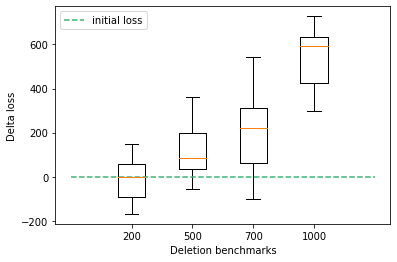

In [111]:
plt.boxplot((delta_loss_200, delta_loss_500, delta_loss_700, delta_loss_1000),
            labels=('200','500','700','1000'))
plt.plot(['0','200','500','700','1000', '2000'], [0, 0, 0, 0, 0, 0], color='mediumseagreen', ls='--',
        label='initial loss')
plt.xlabel('Deletion benchmarks')
plt.ylabel('Delta loss')
plt.legend()

### Asymmetry

In [112]:
list_encoded_asym = random.sample(list(df_encoded_asym['sub']), 100)
df_encoded_asym_X = df_encoded_asym[df_encoded_asym['sub'].astype(int).isin(list_encoded_asym)]

list_ctrl = list(set(list(df_encoded_hcp['sub'][:200])) - set(list(df_encoded_asym_X['sub'].astype(int))))
df_encoded_hcp_X = df_encoded_hcp[df_encoded_hcp['sub'].isin(list_ctrl)]

NameError: name 'df_encoded_asym' is not defined

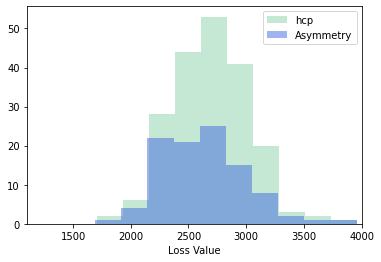

In [50]:
plt.subplot()
plt.xlim([1100, 4000])
plt.hist(df_encoded_hcp_X.loss, color='mediumseagreen', alpha=0.3, label='hcp')
plt.hist(df_encoded_asym_X.loss, color='royalblue', alpha=0.5, label='Asymmetry') 
plt.xlabel('Loss Value')
plt.legend()

In [51]:
F,p = mannwhitneyu(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X.loss, df_encoded_asym_X.loss)
print(p)

0.04827931982685287
0.11049822222033816
